In [30]:
from tqdm.notebook import tqdm # progress bar
from tqdm.contrib.concurrent import process_map  # use multiprocessing for web scrapping
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown as md

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants

Load shot numbers with Interferomety data

In [31]:
URL = "https://golem.fjfi.cvut.cz/RetroActions/1122Interferometry"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
a_tags = soup.find_all('a')
shot_nums = [int(a_tag.text) for a_tag in a_tags]

len(shot_nums)

1191

In [32]:
# seems the first 10 shots have the same ne_lav.csv
shot_nums = shot_nums[10:]

Some code recycled from  
[Interferomety notebook](http://golem.fjfi.cvut.cz/shots/36742/Diagnostics/Interferometry/analysis.html)

In [33]:
!pip3 install isfreader
import isfreader

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [34]:
ds = np.DataSource('data')   # temporary sotarge for downloaded files
data_URL = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/Interferometry/DAS_raw_data_dir/ch{ch_id}.isf'
scalars_URL = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/BasicDiagnostics/Results/{name}'
meta_URL = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/{name}'

In [35]:
def load_channel(shot_no, chanel_id, channel_name=None, in_ms=True):
    fname = ds.open(data_URL.format(shot_no=shot_no, ch_id=chanel_id)).name
    try:
        data = isfreader.read_file(fname)
    except:
        return None
    
    if data.dtype != np.float_:
        return None
    signal = pd.Series(data[:,1], name=channel_name,
                       index=pd.Index(data[:,0], name='time'))
    if in_ms:
        signal.index *= 1e3  # s -> ms
    return signal

In [36]:
def get_scalar(shot_no : int, name : str, type = float, URL = scalars_URL):
    return type(ds.open(URL.format(shot_no=shot_no, name=name)).read())

def get_plasma_params(shot_no: int):
    is_plasma = get_scalar(shot_no, 'is_plasma', bool)
    t_plasma_start = get_scalar(shot_no, 't_plasma_start')
    t_plasma_end = get_scalar(shot_no, 't_plasma_end')
    return is_plasma, t_plasma_start, t_plasma_end

In [37]:
def load_density_data(shot_no: int):
    '''load plasma density from csv'''
    density_ULR = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/Interferometry/ne_lav.csv'
    csv =  ds.open(density_ULR.format(shot_no=shot_no))
    return pd.read_csv(csv, names = ['time', 'density'], index_col='time').squeeze()

In [38]:
from dataclasses import dataclass
import datetime

def load_corrected_density(shot_no: int):
    density_fix_fname = 'ne_%i.pkl' % shot_no
    if not ds.exists(density_fix_fname):
        return None
    else:
        file = ds.abspath(density_fix_fname)
        return pd.read_pickle(file)
    
def save_corrected_density(shot_no :int, density : pd.Series):
    density_fix_fname = 'ne_%i.pkl' % shot_no
    density.to_pickle(ds._destpath + "/" + density_fix_fname)
    
@dataclass
class InterferometryShot:
    '''Dataclass for interferometry and metadata'''
    shot_no: int
    is_plasma : bool
    plasma_start : float
    plasma_end : float
    has_interferometry_data : bool
    has_complete_interferometry: bool
    analog_interferometer : pd.DataFrame  = None
    digital_interferometer : pd.DataFrame = None
    digital_interferometer_fixed : pd.DataFrame = None
    sawtooh_reference : pd.DataFrame = None
    diode_output : pd.DataFrame = None
    session_id : int = None
    shot_time : datetime = None
        
    def compute_corrected_density(self, recompute = False):
        self.digital_interferometer_fixed = load_corrected_density(self.shot_no)
        if self.digital_interferometer_fixed is None or recompute:
            try:
                self.digital_interferometer_fixed = get_corrected_density(self)
            except:
                self.digital_interferometer_fixed = None
            if  self.digital_interferometer_fixed is not None:
                save_corrected_density(self.shot_no, self.digital_interferometer_fixed)

In [39]:
omega_carrier = 2*np.pi*71e9  # 71 GHz microwave generator
a = 0.085   # limiter radius
L = 2*a  # central plasma chord estimate
prop_const = constants.elementary_charge**2 /  \
             (2*omega_carrier* constants.speed_of_light*constants.epsilon_0*constants.m_e)

def get_shot_data(shot_no : int):
    is_all = True
    is_complete = True
    try:
        analog = load_channel(shot_no, 4, 'analog')
        analog *=  1./ prop_const / L
        analog = analog
    except IOError:
        analog = None 
        is_all = False
        
        
    try: 
        digital = load_density_data(shot_no)
    except IOError:
        digital = None 
        is_all = False
    
    try:
        diode_output = load_channel(shot_no, 1, 'diode_output')
        sawtooh_reference = load_channel(shot_no, 3, 'sawtooh_reference')
    except:
        diode_output, sawtooh_reference = None, None
    try: 
        is_plasma, t_start, t_end = get_plasma_params(shot_no)
    except IOError:
        is_plasma, t_start, t_end = None, None, None
        is_all = False
    
    if digital is not None and is_plasma and ( digital.index[-1] < t_end or digital.index[0] > t_start ):
        is_complete = False
    
    if diode_output is not None and is_plasma and ( diode_output.index[-1] < t_end or diode_output.index[0] > t_start):
        is_complete = False
    
    shot_date  = get_scalar(shot_no,'shot_date', str, meta_URL).replace("\n", "")
    shot_time  = get_scalar(shot_no,'shot_time', str, meta_URL).replace("\n", "")
    
    shot_datetime = datetime.datetime.strptime(shot_date+ " " +shot_time, "%y-%m-%d %H:%M:%S" )
    sesstion_id = get_scalar(shot_no, 'session_id', int, meta_URL)
    
    return InterferometryShot(shot_no = shot_no,
                              analog_interferometer = analog,
                              digital_interferometer = digital,
                              is_plasma = is_plasma,
                              plasma_start = t_start,
                              plasma_end = t_end,
                              has_interferometry_data = is_all,
                              has_complete_interferometry=is_complete,
                              session_id = sesstion_id,
                              shot_time = shot_datetime,
                              diode_output=diode_output,
                              sawtooh_reference = sawtooh_reference)

### Download data

! this will download about **37 GB** !

In [40]:
def download_shot_data(shot_no: int):
    try:
        _ = get_shot_data(shot_no)
        return True
    except :
        return False
#has_data = process_map(download_shot_data, shot_nums,max_workers=2, chunksize = 1)
#md('All data downloaded') if np.all(has_data) else md('something failed')

In [41]:
def ends_with_zero(data, threshold = 1e18, start = 1, end = 0):
    '''Check if data are below threshold in selected time slice (with respect to data endpoint)'''
    if start < end:
        raise ValueError("Must be start > end")
    data = np.abs(data)
    return np.all(data[(data.index[-1]-start):(data.index[-1]-end)] < threshold)

def is_zero_in_slice(data, threshold = 1e18, start = 1, end = 2):
    '''Check if data are below threshold in selected time slice'''
    if start > end:
        raise ValueError("Must be start < end")
    if start < data.index[0]:
        start = data.index[0]
    end = end if end < data.index[-1] else data.index[-1]
    data = np.abs(data)
    return np.all(data[start:end] < threshold)

def starts_at_zero(data, threshold = 1e18, start = 0, end = 1):
    if start > end:
        raise ValueError("Must be start < end")
    data = np.abs(data)
    return np.all(data[(data.index[0]+start):(data.index[0]+end)] < threshold)

In [42]:
def plot_density_data(data: InterferometryShot):
    if not data.has_interferometry_data:
        return
    ax = data.digital_interferometer.plot()
    
    if data.analog_interferometer:
        data.analog_interferometer.plot(ax=ax)
    
    if data.digital_interferometer_fixed:
        data.digital_interferometer_fixed.plot(ax=ax, color = 'k')
    
    if data.is_plasma:
        ax.axvline(data.plasma_start)
        ax.axvline(data.plasma_end)
    plt.show()

In [43]:
def is_valid_interferometry(inter_data: pd.Series, shot_data: InterferometryShot, 
                            zer_thr : int = 5, pos_thr: int = 75):
    
    # return None on no data
    if inter_data is None:
        return None, None, None
        
    # do not check shot witouth plasma
    if not shot_data.is_plasma:
        is_valid, positive, e_zero = True, None, None
        return is_valid, positive, e_zero
    
    #
    # ends at 'zero' (at least zer_thr of maximum)
    threshold = inter_data.max() * zer_thr /100
    threshold = np.max([5e16,threshold]) 
    
    s_start = shot_data.plasma_end + 1.  # 1   ms after plasma end
    s_end = inter_data.index[-1]   -.5   #  .5 ms before data ends 
                                         #  (data  sometimes ends with small peak)
        
    # or check at least .5 ms of
    if s_start > s_end: 
        s_start = inter_data.index[-1] - 1
    
    e_zero = is_zero_in_slice(inter_data, threshold=threshold, 
                              start = s_start, end = s_end)
    
    #
    # is has positive values if there is a plasma
    plasma_slice  = inter_data[shot_data.plasma_start : shot_data.plasma_end]
    if plasma_slice.size == 0:
        is_valid, positive, e_zero = False, None, None
    else:
        positive = np.count_nonzero(plasma_slice > 1e16) / plasma_slice.size* 1e2
        
        # has more than pos_thr% of positive values
        is_positive = True if positive > pos_thr else False
        
        s_start = shot_data.plasma_start + 2  #  ms
        s_end = shot_data.plasma_end - 2      #  ms
            
        if s_start > s_end: 
            negative_for_plasma = False    
        else:
            negative_for_plasma = is_zero_in_slice(inter_data, threshold=0., start=s_start, end=s_end)
        
        is_valid = e_zero and is_positive
        
    return is_valid, positive, e_zero, negative_for_plasma

Code stolen from [LL](http://golem.fjfi.cvut.cz/shots/40318/Diagnostics/Interferometry/analysis.html) 

Copy/pasta 
changes:
- calculate_spectrum make f_s local variable  
- calc_lost_phase and calc_dphase make f_base local variable

In [44]:
from scipy import signal as sigproc
from scipy.fft import next_fast_len
import math

def calculate_spectrum(signal, f_s, target_dfreq=10):
    nperseg = int(f_s / target_dfreq)
    f, psd = sigproc.welch(signal[:, 1], fs=f_s, nperseg=nperseg, nfft=next_fast_len(nperseg))
    return f, psd


def freq_filter(signal, sos_filter):
    signal[:, 1] = sigproc.sosfiltfilt(sos_filter, signal[:, 1])
    return signal


def find_peaks(data):
    peaks_indexes, _ = sigproc.find_peaks(data[:, 1])
    return np.vstack((data[peaks_indexes, 0], data[peaks_indexes, 1])).T

def initial_phase_shift(peaks, peaks_ref, mixer_filtered):
    phase_mean = peaks[0, 0] - peaks_ref[0, 0]
    mixer_filtered[:, 0] -= phase_mean
    peaks[:, 0] -= phase_mean
    return peaks, mixer_filtered

def differences(signal):
    data = signal.copy()
    x, y = data.shape
    for i in range(1, int(x) - 1):
        data[i, 0] = signal[i, 0] - signal[i - 1, 0]
        data[i, 1] = signal[i + 1, 0] - signal[i, 0]

    return np.hstack((signal, data))

def cut_edges(diff_peaks_mixer, diff_peaks_ref, peaks, peaks_ref):
    diff_peaks_mixer = diff_peaks_mixer[(diff_peaks_mixer[0, 0] < diff_peaks_mixer[:, 0]) & (diff_peaks_mixer[:, 0] < diff_peaks_mixer[-1, 0])]
    diff_peaks_ref = diff_peaks_ref[(diff_peaks_ref[0, 0] < diff_peaks_ref[:, 0]) & (diff_peaks_ref[:, 0] < diff_peaks_ref[-1, 0])]
    peaks = peaks[(peaks[0, 0] < peaks[:, 0]) & (peaks[:, 0] < peaks[-1, 0])]
    peaks_ref = peaks_ref[(peaks_ref[0, 0] < peaks_ref[:, 0]) & (peaks_ref[:, 0] < peaks_ref[-1, 0])]
    return diff_peaks_mixer, diff_peaks_ref, peaks, peaks_ref


def remove_basic_diff(diff_peaks_mixer, diff_peaks_ref):
    basic_diff = np.mean(diff_peaks_ref[:, 2])
    diff_peaks_mixer[:, 2] -= basic_diff
    diff_peaks_ref[:, 2] -= basic_diff
    return diff_peaks_mixer, diff_peaks_ref

def sort_differencies(diff_peaks_mixer):
    data = diff_peaks_mixer.copy()
    x, y = data.shape
    for i in range(0, x):
        if data[i, 2] < 0:
            data[i, 2] *= 0.9
    data[:, 2] = abs(data[:, 2])

    return data[data[:, 2].argsort()[::-1]]

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def without_correction(mixer_filtered, ref_saw_filtered):
    mixer_data = mixer_filtered.copy()
    ref_saw_data = ref_saw_filtered.copy()
    peaks = find_peaks(mixer_data)
    peaks_ref = find_peaks(ref_saw_data)
    peaks, mixer_data = initial_phase_shift(peaks, peaks_ref, mixer_data)
    diff_peaks_mixer = differences(peaks)
    diff_peaks_ref = differences(peaks_ref)
    diff_peaks_mixer, diff_peaks_ref, peaks, peaks_ref = cut_edges(diff_peaks_mixer, diff_peaks_ref, peaks, peaks_ref)
    diff_peaks_mixer, diff_peaks_ref = remove_basic_diff(diff_peaks_mixer, diff_peaks_ref)

    return mixer_data, peaks, peaks_ref, diff_peaks_mixer, diff_peaks_ref

def basic_cycle(mixer_filtered, ref_saw_filtered):
    peaks = find_peaks(mixer_filtered)
    peaks_ref = find_peaks(ref_saw_filtered)
    peaks, mixer_filtered = initial_phase_shift(peaks, peaks_ref, mixer_filtered)
    diff_peaks_mixer = differences(peaks)
    diff_peaks_ref = differences(peaks_ref)
    diff_peaks_mixer, diff_peaks_ref, peaks, peaks_ref = cut_edges(diff_peaks_mixer, diff_peaks_ref, peaks, peaks_ref)
    diff_peaks_mixer, diff_peaks_ref = remove_basic_diff(diff_peaks_mixer, diff_peaks_ref)
    sorted_diff_mixer = sort_differencies(diff_peaks_mixer)
    return peaks, peaks_ref, mixer_filtered, diff_peaks_mixer, diff_peaks_ref, sorted_diff_mixer

def find_nearest(array, value):
    array = array.copy()
    x, y = array.shape
    array_data = np.zeros((x, 1))
    for i in range(0, x):
        array_data[i, 0] = array[i, 0]
    idx = (np.abs(array_data[:, 0] - value)).argmin()
    return array_data[idx]


def calc_dphase_unchanged(peaks, peaks_ref):
    x_peaks, y_peaks = peaks.shape
    x_ref_peaks, y_ref_peaks = peaks_ref.shape

    dphase = np.ones((min(x_peaks, x_ref_peaks), 2))
    for i in range(0, int(len(dphase))):
        dphase[i, 0] = peaks[i, 0] # TODO: zmenit na peaks_ref?
        dphase[i, 1] = peaks[i, 0] - peaks_ref[i, 0]

    return dphase

def calc_lost_phase(peaks, peaks_ref, diff_peaks_mixer, diff_peaks_ref, f_base):
    dphase = calc_dphase_unchanged(peaks, peaks_ref)
    time_interval = 0.1 # ms
    indexes = np.argwhere(dphase[:, 0] > (dphase[-1, 0] - time_interval))
    data = dphase[indexes[:, 0]]
    return 2*math.pi*f_base*np.average(data[:, 1]), dphase

def repair(mixer_filtered, ref_saw_filtered, lost_phase, dphase):
    peaks, peaks_ref, mixer_filtered, diff_peaks_mixer, diff_peaks_ref, sorted_diff_mixer = basic_cycle(mixer_filtered, ref_saw_filtered)
    # make repairing cycle
    number_of_bad_peaks = round(lost_phase/(2*math.pi))
    remainder = lost_phase - 2*math.pi*number_of_bad_peaks
    x_peaks_mixer, y_peaks_mixer = peaks.shape
    x_peaks_ref, y_peaks_ref = peaks_ref.shape
    deriv = dphase.copy()
    deriv[:, 1] = np.gradient(dphase[:, 1])
    deriv[:, 1] = smooth((deriv[:, 1]), 10)
    deriv_sort = deriv.copy()
    # deriv_sort[:, 1] = abs(deriv_sort[:, 1])
    deriv_sort = deriv_sort[deriv_sort[:, 1].argsort()[::-1]]
    bad_peaks_indexes = np.empty((0, 1))
    k = 0
    l = 0
    while k < number_of_bad_peaks:
        index = np.argwhere(diff_peaks_mixer[:, 0] == deriv_sort[l, 0])
        if (l > 0) and (abs((index[0, 0] - find_nearest(bad_peaks_indexes, index[0, 0]))) < 10):
            l += 1
        else:
            bad_peaks_indexes = np.vstack((bad_peaks_indexes, index[0, 0]))
            peaks_ref = np.delete(peaks_ref, index, 0)
            k += 1
            l += 1

    if number_of_bad_peaks == 0:
        for i in range(x_peaks_mixer):
            if remainder > math.pi:
                index = np.argwhere(diff_peaks_mixer[:, 0] == deriv_sort[i, 0])
                peaks_ref = np.delete(peaks_ref, index, 0)
                bad_peaks_indexes = np.vstack((bad_peaks_indexes, index[0, 0]))

    return peaks, peaks_ref, bad_peaks_indexes, diff_peaks_mixer, deriv

def calc_dphase(peaks, peaks_ref, repaired_mixer_peaks, repaired_ref_peaks, f_base):
    x_peaks, y_peaks = peaks.shape
    x_ref_peaks, y_ref_peaks = peaks_ref.shape

    dphase = np.ones((min(x_peaks, x_ref_peaks), 2))
    dphase[:, 1] *= 2*math.pi*f_base
    for i in range(0, int(len(dphase))):
        dphase[i, 0] = peaks_ref[i, 0]
        dphase[i, 1] = peaks[i, 0] - peaks_ref[i, 0]

    x_peaks, y_peaks = repaired_mixer_peaks.shape
    x_ref_peaks, y_ref_peaks = repaired_ref_peaks.shape

    dphase1 = np.ones((min(x_peaks, x_ref_peaks), 2))
    for i in range(0, int(len(dphase1))):
        dphase1[i, 0] = repaired_ref_peaks[i, 0]
        dphase1[i, 1] = repaired_mixer_peaks[i, 0] - repaired_ref_peaks[i, 0]

    dphase1[:, 1] *= 2*math.pi*f_base
    return dphase, dphase1

In [45]:
def pd_series_no_ndarray(sr):
    return np.array((sr.index, sr)).T

def get_corrected_density(shot_data: InterferometryShot):
    if shot_data.sawtooh_reference is None or shot_data.diode_output is None:
        return None
    
    ref_saw = pd_series_no_ndarray(shot_data.sawtooh_reference)
    mixer = pd_series_no_ndarray(shot_data.diode_output)
    

    t_plasma_end = shot_data.plasma_end
    
    # In[10]:
    x, y = mixer.shape
    f_s = x / (mixer[-1, 0] - mixer[0, 0])  # ms -> kHz


    # In[12]:
    ref_saw_f, ref_saw_psd = calculate_spectrum(ref_saw, f_s)
    mixer_f, mixer_psd = calculate_spectrum(mixer, f_s)
    f_base = mixer_f[mixer_psd.argmax()]


    # In[15]:
    base_band_hwidth = 50  # kHz
    base_band_filter = sigproc.iirfilter(8, [f_base - base_band_hwidth, f_base + base_band_hwidth], 
                                        fs=f_s, btype='bandpass', output='sos')

    # In[17]:
    mixer_filtered = freq_filter(mixer, base_band_filter)
    ref_saw_filtered = freq_filter(ref_saw, base_band_filter)

    # cut 0.1 ms from the beginning and from the end
    # In[18]:
    mixer_filtered = mixer_filtered[(mixer_filtered[:, 0] < (mixer_filtered[-1, 0] - 0.1)) & ((mixer_filtered[0, 0] + 0.1) < mixer_filtered[:, 0])]
    ref_saw_filtered = ref_saw_filtered[(ref_saw_filtered[:, 0] < (ref_saw_filtered[-1, 0] - 0.1)) & ((ref_saw_filtered[0, 0] + 0.1) < ref_saw_filtered[:, 0])]

        
    # In[33]:    
    mixer_filtered_no_corr, peaks_no_corr, peaks_ref_no_corr, diff_peaks_mixer_no_corr, diff_peaks_ref_no_corr = without_correction(mixer_filtered, ref_saw_filtered)
    lost_phase, dphase_zero = calc_lost_phase(peaks_no_corr, peaks_ref_no_corr, diff_peaks_mixer_no_corr, diff_peaks_ref_no_corr, f_base)
    repaired_mixer_peaks, repaired_ref_peaks, bad_peaks_indexes, diff_peaks_mixer, deriv = repair(mixer_filtered, ref_saw_filtered, lost_phase, dphase_zero)
    dphase, dphase1 = calc_dphase(peaks_no_corr, peaks_ref_no_corr, repaired_mixer_peaks, repaired_ref_peaks,f_base)
    dphase1[:, 1] = smooth(dphase1[:, 1], 100)

    # In[34]:
    omega_carrier = 2 * np.pi * 71e9  # 71 GHz microwave generator
    a = 0.085  # limiter radius
    L = 2 * a  # central plasma chord estimate
    prop_const = constants.elementary_charge ** 2 / (2 * omega_carrier * constants.speed_of_light * constants.epsilon_0 * constants.m_e)

    # In[35]:
    ne_lav = dphase1.copy()
    ne_lav[:, 1] = ne_lav[:, 1] * (1 / (prop_const*L))
    ne_lav = ne_lav[(ne_lav[:, 0] >= 0) & (ne_lav[:, 0] <= (t_plasma_end + 5))]
    
    return pd.Series(data = ne_lav[:,1], name='density_repaired',
                       index=pd.Index(ne_lav[:,0], name='time'))

In [46]:
data = list()
for shot_no in tqdm(shot_nums):
    shot_data = get_shot_data(shot_no)
    if not shot_data.has_interferometry_data or not shot_data.is_plasma:
        continue
    shot_data.compute_corrected_density()
    
    analog =  is_valid_interferometry(shot_data.analog_interferometer, shot_data)
    digital = is_valid_interferometry(shot_data.digital_interferometer, shot_data)
    digital_fixed = is_valid_interferometry(shot_data.digital_interferometer_fixed, shot_data)
    
    data.append([shot_no, shot_data.shot_time, shot_data.session_id,
                 shot_data.is_plasma, shot_data.has_complete_interferometry,
                 *analog, *digital, *digital_fixed])

  0%|          | 0/1181 [00:00<?, ?it/s]

/home/marek/anaconda3/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 25002 is greater than input length  = 10000, using nperseg = 10000
  warnings.warn('nperseg = {0:d} is greater than input length '


UnboundLocalError: local variable 'negative_for_plasma' referenced before assignment

In [ ]:
df = pd.DataFrame(data, columns = ('shot_no', "time", "sesstion", "is_plasma", "is_complete",
                                   "density_analog", "positive_analog", "zero_analog", "negative_in_plasma_analog",
                                   "density_digital", "positive_digital", "zero_digital", "negative_in_plasma_digital",
                                   "density_fix", "positive_fix", "zero_fix", "negative_in_plasma_no_fix" ))
df = df.set_index('shot_no')
df

In [ ]:
df.density_fix.isna().sum() / df.density_fix.count() *100

In [ ]:
df = df[df.is_complete == True]

In [ ]:
validity = lambda x : x.sum() / x.count() * 100.


validity_analog  = validity(df.density_analog)
validity_digital = validity(df.density_digital)
validity_fix = validity(df.density_fix)


md("""
### %.2f%% of analog processed density is valid 
### %.2f%% of digitally processed density is valid
### %.2f%% of digitally fixed  density is valid""" % (validity_analog, validity_digital, validity_fix))

------------
### Density error and time 
(relative time in session)

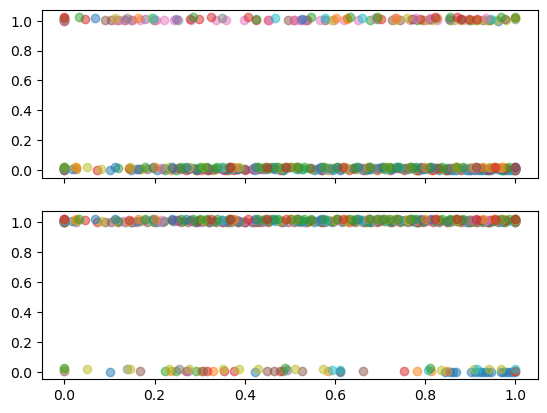

In [21]:
groups = df.groupby('sesstion')

fig, (ax, ax2) = plt.subplots(nrows = 2, sharex = True)
offset = 0.


for group, group_df in groups:
    if group_df.time.count() < 10:
        continue
    if np.all(group_df.density_digital == False):
        continue
    
    time = (group_df.time - group_df.time.iat[0])
    time_sess_length = (group_df.time.iat[-1] - group_df.time.iat[0]).total_seconds()
    time_sec = time.apply(lambda x : x.total_seconds())
    time_scaled = time_sec / time_sess_length


    digital = group_df.density_digital.astype(int) + offset
    offset += .001
    ax.scatter(time_scaled, digital, alpha = .5)
    
    group_df.density_fix.fillna(value=False, inplace=True)
    digital_fix  = group_df.density_fix.astype(int) + offset
    ax2.scatter(time_scaled, digital_fix, alpha = .5)

--------

Some plots for tuning and testing parameters

In [22]:
def adv_plot(shot_no:int, ax : plt.Axes = None, kind : str = 'digital', add_info = True):
    if not ax:
        fig, ax = plt.subplots()
    shot_data = get_shot_data(shot_no)
    
    if kind  == 'digital':
        density = shot_data.digital_interferometer
    elif kind == "analog" :
        density  = shot_data.analog_interferometer
    elif kind == 'digital_fixed' :
        shot_data.compute_corrected_density()
        density  = shot_data.digital_interferometer_fixed
    else:
        return
    
    density.plot(ax = ax)
    
    if not add_info:
        return ax
    threshold = density.max() * .05
    threshold = np.max([5e16,threshold]) 
    
    step = .5
    if shot_data.is_plasma:
        s_end = density.index[-1] - shot_data.plasma_end
    else:
        s_end = 5
    for t_slice in np.arange(0,s_end,step)[:-2]:
        t_start = density.index[-1] - t_slice - step
        t_end  = density.index[-1] - t_slice
        is_zero = is_zero_in_slice(density, threshold=threshold, 
                                 start = t_start, end = t_end)
        color = '#ABB2B9' if is_zero else "#E74C3C"
        ax.axvspan(t_start,t_end, color = color, alpha = .5)
    if shot_data.is_plasma:
        if kind  == 'digital':
            negative = df.loc[shot_no].positive_digital
        elif kind == "analog" :
            negative = df.loc[shot_no].positive_analog
        elif kind == 'digital_fixed' :
            negative = df.loc[shot_no].positive_fix

        
        ax.text(0.25, 0.25, f'{negative:.1f}%>0', horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=1'))

        ax.axvline(shot_data.plasma_start, c = 'green')
        ax.axvline(shot_data.plasma_end , c = 'green')
        
    ax.axhline(0, c = 'k', ls = '--')
    
    return ax

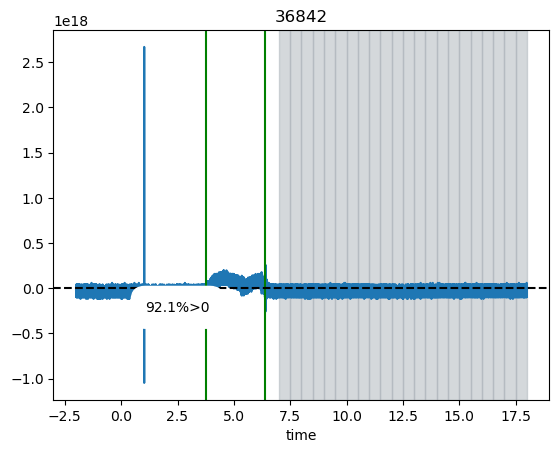

In [46]:
for shot_no in df[df.density_analog == True].index:
    ax = adv_plot(shot_no, kind = 'analog')
    ax.set_title(shot_no)

In [ ]:
for shot_no in df[(df.density_digital == False) & (df.zero_digital == True)].index:
    ax = adv_plot(shot_no)
    ax.set_title(shot_no)

In [ ]:
for shot_no in df[(df.density_fix == True) & (df.density_digital == False)].index[::10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed')
    adv_plot(shot_no, kind = 'digital', ax = ax, add_info=False)
    ax.set_title(shot_no)
    plt.show()

In [ ]:
for shot_no in df[df.density_fix == False].index:
    ax = adv_plot(shot_no, kind = 'digital_fixed')
    ax.set_title(shot_no)